In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

from tensorflow.keras.utils import plot_model

#tensorboard: currently some error
#!pip install -U tensorboardcolab
#from tensorboardcolab import *

# json and pretty print
import json
import pprint
# to persist the numpy arrays data
import h5py
# handle logging
tf.logging.set_verbosity(tf.logging.INFO)

print(tf.__version__)
df = pd.read_csv('paracetamol_short.csv')
print(df.dtypes.value_counts())
print(df.columns.tolist())
print('length of columns :', len(df.columns.tolist()))
print(df.count())
df.head()

1.12.0
float64    2
object     1
int64      1
dtype: int64
['quantity', 'kgPrice', 'dateUnix', 'dateIso']
length of columns : 4
quantity    2311
kgPrice     2311
dateUnix    2311
dateIso     2311
dtype: int64


,quantity,kgPrice,dateUnix,dateIso
0,1.0,0.750000,1483311600,01/01/2017
1,5986.0,3.039779,1483311600,01/01/2017
2,14137.2,3.356817,1483311600,01/01/2017
3,2500.0,6.887044,1483311600,01/01/2017
4,17789.2,3.401647,1483311600,01/01/2017


# Functions

In [2]:
# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):\
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])
  
def plot_prediction(original, predicted):
    #fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    # Get subplots
    f, (plt1, plt2, plt3) = plt.subplots(3)
    # Get Daily errors
    
    a = original
    b = predicted
    if(len(original.shape) > 1):
        a = original.reshape(original.shape[0]*original.shape[1])
    if(len(predicted.shape) > 1):
        b = predicted.reshape(predicted.shape[0]*predicted.shape[1])
    
    daily_errors = abs(a - b)
    t = 7
    weekly_errors = temp = [np.float(np.sum(daily_errors[i:i+t])/t) for i in range(0, len(daily_errors), t)]
  
    # Calculate R2 metric
  
    # FROM wikipedia: 
    # Values of R2 outside the range 0 to 1 can occur when the model fits the data worse than a horizontal hyperplane. 
    # This would occur when the wrong model was chosen.
    m = np.mean(a)
    ss_tot = np.sum(np.power((a - m), 2))
    ss_res = np.sum(np.power((a - b), 2))
    r_square = 1 - (ss_res / ss_tot)
    r_square = "{0:.4f}".format(r_square)
    mape = calc_mape(b, a)
  
    # Get weekly errors
    # plot original vs predicted  
    plt1.plot(original, color='black', label = 'Original data') 
    plt1.plot(predicted, color='blue', label = 'Predicted data')

    # PLOT DAILY ERRORS
    plt2.plot(daily_errors, color='red')
    
    # PLOT WEEKLY ERRORS
    for i, e in enumerate(weekly_errors):
        plt3.bar(x=i*7, height=e, width=5, color='red')

    plt1.set_title('Actual and Predicted - R2: '+str(r_square) + ' - MAPE:'+str(mape))  
    plt2.set_title('Daily Errors')
    plt3.set_title('Weekly Errors')
  
    # IF YOU ARE USING COLAB, USE THIS:
    plt.subplots_adjust(left=1, bottom=1, right=4, top=3, wspace=None, hspace=1)
  
    # IF YOU ARE USING YOUR LOCAL AND SHOWING THE RESULTS USE THE FOLLOWING:
    # plt.subplots_adjust(left=0.05, bottom=0.05, right=0.90, top=0.90, wspace=None, hspace=0.4)
    
    plt.show()

# returns normalized dataset between a and b
def minmax_norm(dataset, a, b):
    # NORMALIZE DATASET
    d = dataset
    mi = np.min(dataset)
    ma = np.max(dataset)

    norm_dataset = ((b-a) * ((d - mi)/(ma - mi))) + a
    return norm_dataset

def minmax_denorm(old_data, val, a=-1, b=1):
    mi = min(old_data)
    ma = max(old_data)

    return ((val - a) * (ma-mi) / (b-a)) + mi

def get_test(X, percentage=0.9):
    iXPercentage = int(len(X) * percentage) 
    X_train_val = X[0:iXPercentage]
    X_test = X[iXPercentage:]
    return X_train_val, X_test
  
def get_data_dict(d_list, windows):
    length = len(d_list[0])
    step = 1
    forecast = 1

    _dict = {}
    for window in windows:
        X = []
        Y = []
        for i in range(0, length, step):
            try:
                # Get windowed data
                windowed_features_list = []
                for j in range(len(d_list)):
                    windowed_features_list.append(d_list[j][i:i+window])

                # ALWAYS TAKE THE FIRST data 
                y_i = d_list[0][i + window + forecast - 1] # indexing is important.
                x_i = np.column_stack(tuple(windowed_features_list))
            except Exception as e:
                print(e)
                break
            
            X.append(x_i)
            Y.append(y_i)
            #print(X)
        _dict[window] = {'X': np.array(X), 'Y': np.array(Y)}
    
    return _dict

In [3]:
dataset = df.copy()
dataset = dataset.drop("dateIso", axis=1)
dataset.head()

,quantity,kgPrice,dateUnix
0,1.0,0.750000,1483311600
1,5986.0,3.039779,1483311600
2,14137.2,3.356817,1483311600
3,2500.0,6.887044,1483311600
4,17789.2,3.401647,1483311600


In [4]:
def fn(group):
    group['weighted_avg_kgprice'] = group['kgPrice'] * group['quantity'] / group['quantity'].sum()
    return group

d_agg = {'weighted_avg_kgprice':'sum', 
         'quantity':'sum'
        }

dataset_weighted = dataset.groupby('dateUnix', sort=False).apply(fn).groupby('dateUnix').agg(d_agg)
dataset_weighted.head(15)
#dataset_weighted

#print(dataset.groupby('dateUnix', sort=False).apply(fn))

,weighted_avg_kgprice,quantity
dateUnix,,
1483311600,3.448643,142727.8
1483398000,4.185645,34300.0
1483484400,4.050100,16000.0
1483570800,3.488540,92137.2
1483657200,3.203516,91000.0
1483743600,3.462037,68500.0
1483830000,4.802115,14000.0
1483916400,3.656298,55500.0
1484089200,4.226170,22500.0


In [5]:
column_names = ['weighted_avg_kgprice', 'quantity']

In [6]:
prices = np.array(dataset_weighted[column_names[0]])
volumes = np.array(dataset_weighted[column_names[1]])
#print(prices)
#print(volumes)

In [7]:
non_normalized_data = get_data_dict(d_list=[prices, volumes], windows=[6, 8, 12])

index 607 is out of bounds for axis 0 with size 607
index 607 is out of bounds for axis 0 with size 607
index 607 is out of bounds for axis 0 with size 607


In [8]:
norm_daily_prices  = minmax_norm(prices, a=-1, b=1)
norm_daily_volumes = minmax_norm(volumes, a=-1, b=1)

normalized_data = get_data_dict(d_list=[norm_daily_prices, norm_daily_volumes], 
                                windows=[6,8,12])

index 607 is out of bounds for axis 0 with size 607
index 607 is out of bounds for axis 0 with size 607
index 607 is out of bounds for axis 0 with size 607


In [9]:
x = normalized_data[6]['X']
y = normalized_data[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

[[-0.91967656  0.43837965]
 [-0.88931587 -0.65435887]
 [-0.89489962 -0.83878681]
 [-0.91803297 -0.07147389]
 [-0.92977449 -0.08293462]
 [-0.91912478 -0.30969028]]
-0.8639204835988725
****************************************************************************************************
[[-0.88931587 -0.65435887]
 [-0.89489962 -0.83878681]
 [-0.91803297 -0.07147389]
 [-0.92977449 -0.08293462]
 [-0.91912478 -0.30969028]
 [-0.86392048 -0.85894287]]
-0.9111222399603639
****************************************************************************************************


# GET BI-DIR LSTM MODEL

In [10]:
w = 6
batch_size = 64

In [11]:
  def build_bidir_lstm_model(tensor_shape):
    # L2 norm regularizer
    regularizer = tf.keras.regularizers.l2(0.01)

    # XAVIER INITIALIZER
#    initializer = tf.keras.initializers.glorot_uniform()

    model = tf.keras.Sequential()

  # hyperbolic tangent is automatically seleceted as activation function
    units = tensor_shape[0]
    model.add(layers.Bidirectional(layers.LSTM(units, return_sequences=True), batch_input_shape=(None, tensor_shape[0], tensor_shape[1])))
    #model.add(layers.LSTM(units, 
                          #batch_input_shape=(None, tensor_shape[0], tensor_shape[1]),
                          #recurrent_regularizer=regularizer,
                          #bias_regularizer=regularizer, 
                          #kernel_regularizer=regularizer
                         #))


    #model.add(layers.LSTM(units, return_sequences=True))
    #model.add(layers.LSTM(units))
    
    model.add(layers.Dense(32,activation='relu'))
    model.add(layers.Dense(32,activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [12]:
daily_model = build_bidir_lstm_model(tensor_shape=(w, 2))
weekly_model = build_bidir_lstm_model(tensor_shape=(w, 2))
monthly_model = build_bidir_lstm_model(tensor_shape=(w, 2))

daily_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 6, 12)             432       
_________________________________________________________________
dense (Dense)                (None, 6, 32)             416       
_________________________________________________________________
dense_1 (Dense)              (None, 6, 32)             1056      
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 193       
Total params: 2,097
Trainable params: 2,097
Non-trainable params: 0
_________________________________________________________________


In [18]:
folder_name = 'models/'
model_save_name = folder_name  + 'daily_crude_oil_bidirlstm_model_w6_b64'
weekly_model_save_name = folder_name  + 'crude_oil_weekly_bidirlstm_model_w6_b64'
monthly_model_save_name = folder_name  + 'crude_oil_monthly_bidirlstm_model_w6_b64'

In [19]:
daily_model.load_weights(model_save_name)
weekly_model.load_weights(weekly_model_save_name)
monthly_model.load_weights(monthly_model_save_name)

In [20]:
norm_x = normalized_data[6]['X']
norm_y = normalized_data[6]['Y']

non_norm_y = non_normalized_data[6]['Y']
print(norm_x.shape)
print(non_norm_y.shape)

(601, 6, 2)
(601,)


# Test On Daily

In [21]:
pred_y = daily_model.predict(norm_x)
pred_yy = minmax_denorm(prices, pred_y, a=-1, b=1)

# Full Dataset Prediction

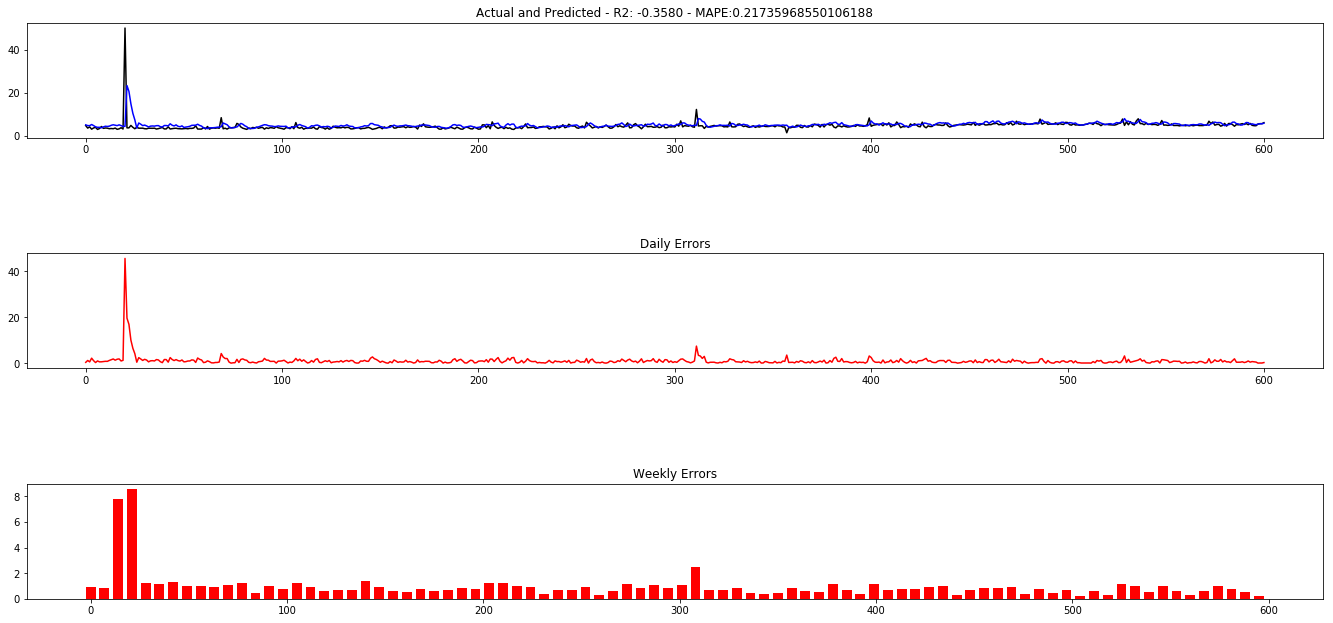

In [22]:
plot_prediction(non_norm_y, pred_yy)

# Last 60 pred

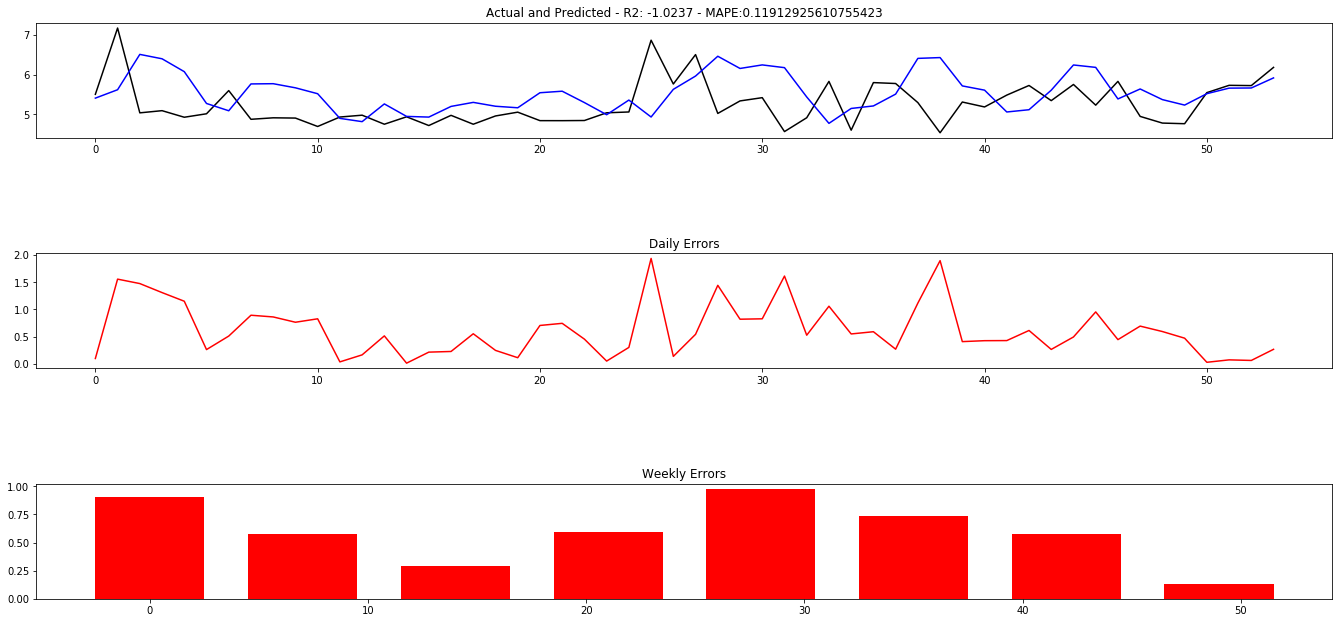

In [23]:
t = prices.shape[0]-60
t_r = prices.shape[0]
plot_prediction(non_norm_y[t:t_r], pred_yy[t:t_r])

 # Last 'a' pred

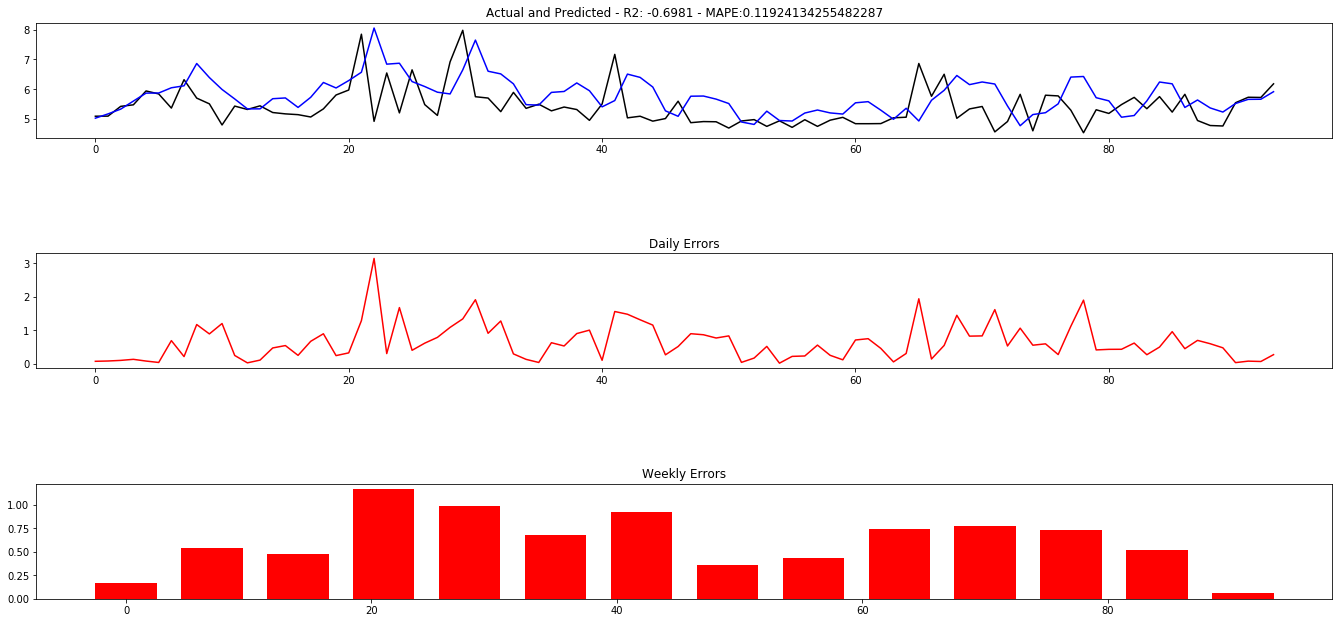

In [24]:
a = 100
t = prices.shape[0]-a
t_r = prices.shape[0]
plot_prediction(non_norm_y[t:t_r], pred_yy[t:t_r])

# Test on Weekly

In [25]:
pred_y = weekly_model.predict(norm_x)
pred_yy = minmax_denorm(prices, pred_y, a=-1, b=1)

# Full Dataset Prediction

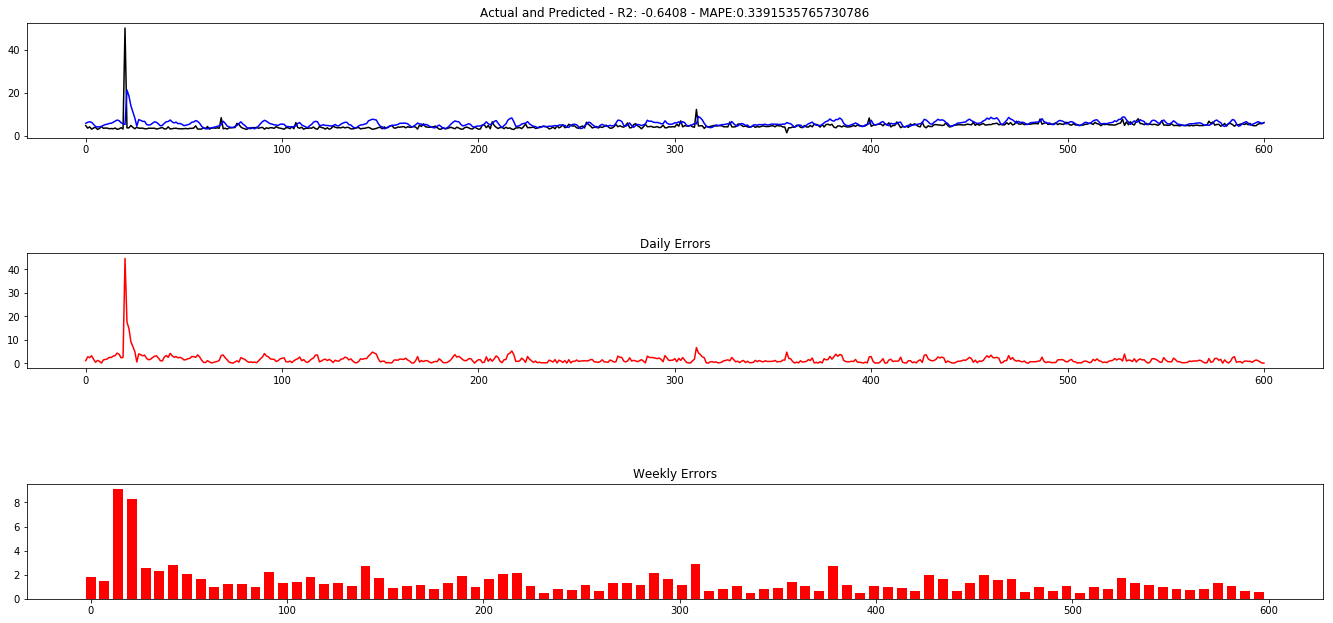

In [26]:
plot_prediction(non_norm_y, pred_yy)

# Last 60 pred

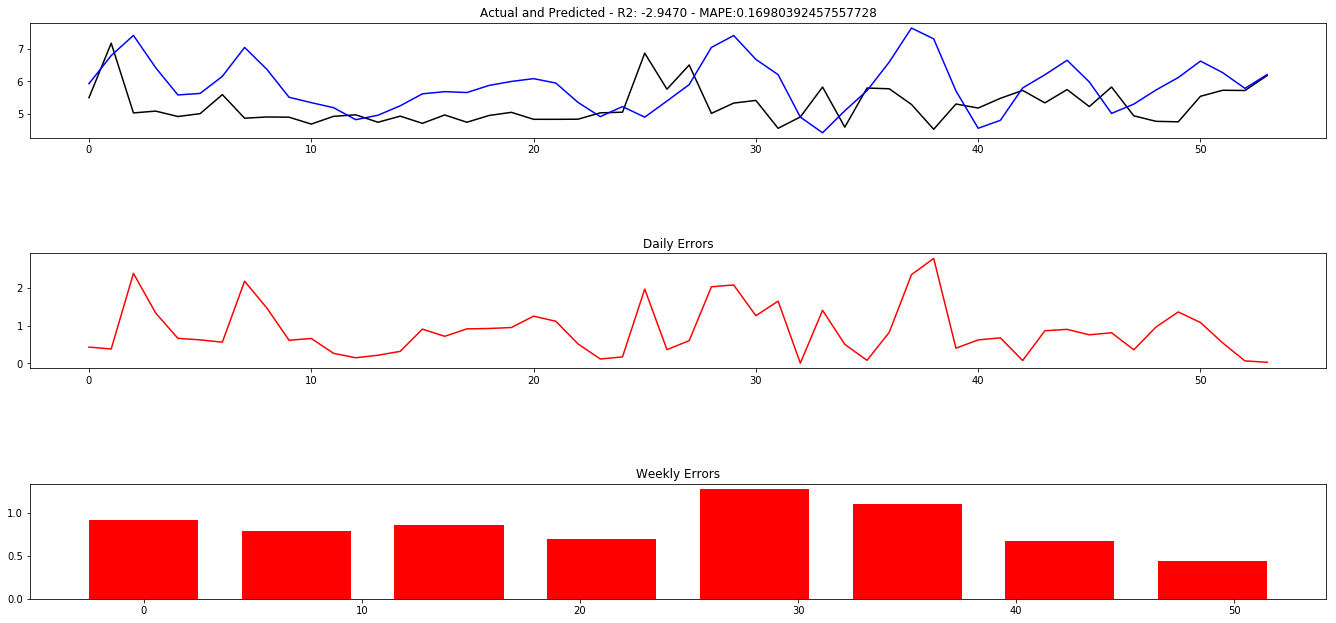

In [27]:
t = prices.shape[0]-60
t_r = prices.shape[0]
plot_prediction(non_norm_y[t:t_r], pred_yy[t:t_r])

# Last 'a' pred

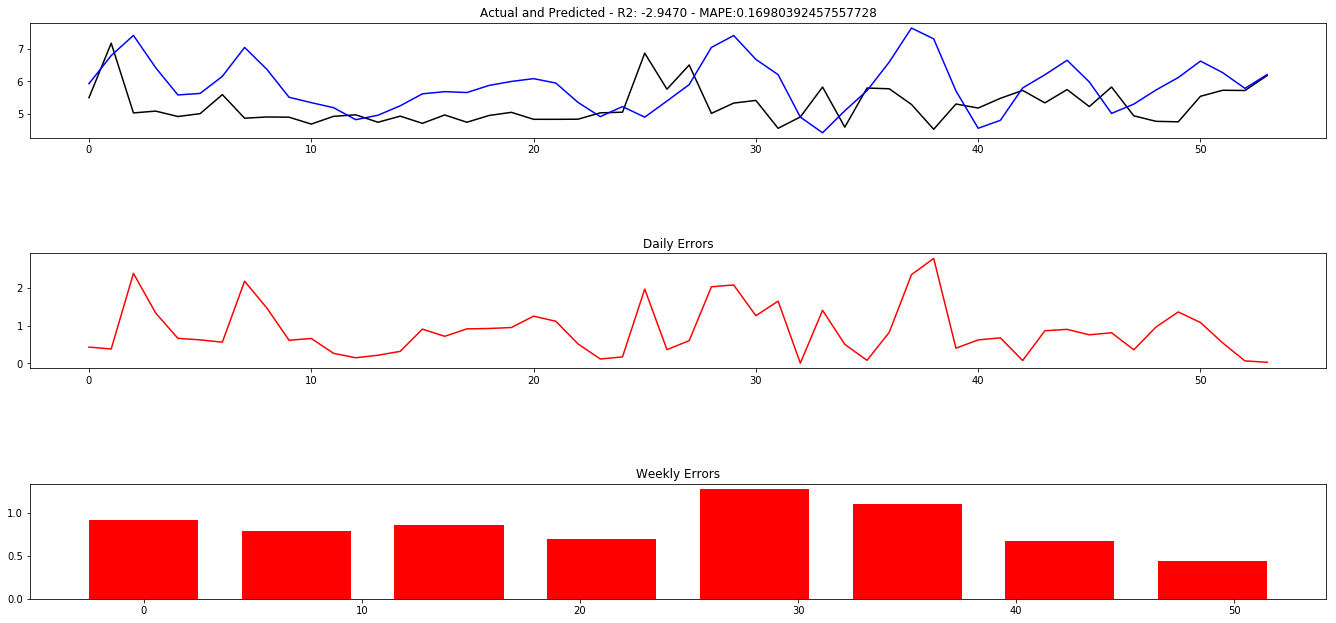

In [28]:
a = 60
t = prices.shape[0]-a
t_r = prices.shape[0]
plot_prediction(non_norm_y[t:t_r], pred_yy[t:t_r])

# Test on Monthly

In [29]:
pred_y = monthly_model.predict(norm_x)
pred_yy = minmax_denorm(prices, pred_y, a=-1, b=1)

# Full Dataset Prediction

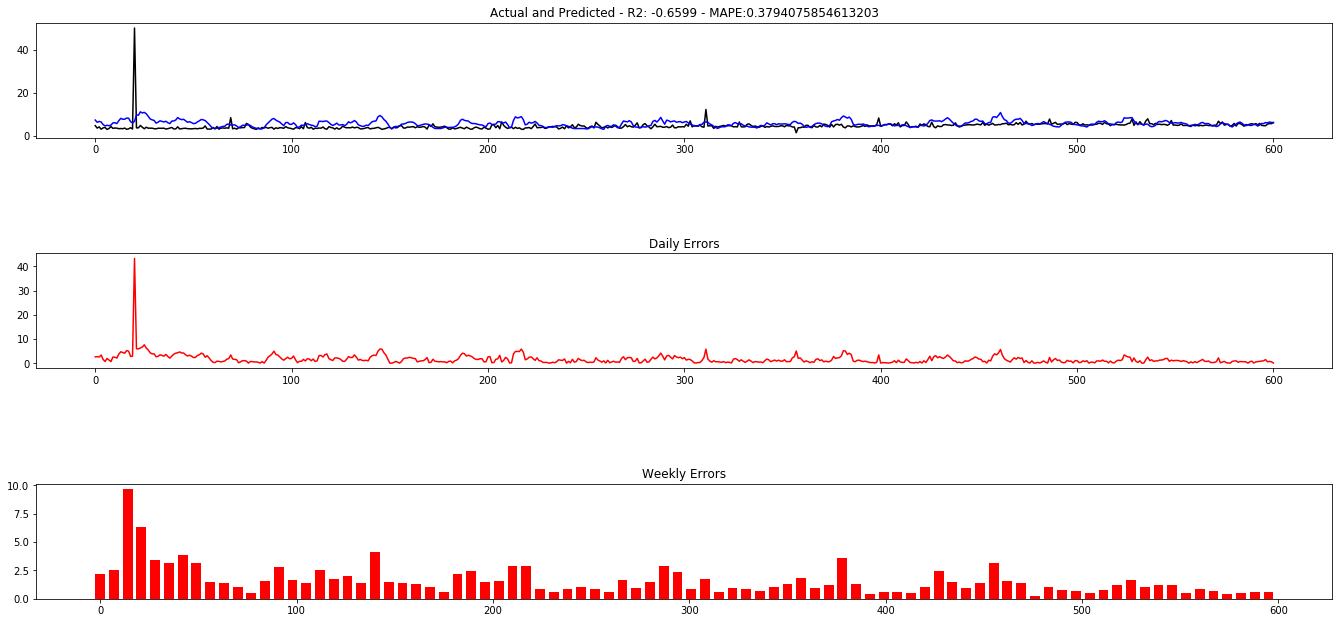

In [30]:
plot_prediction(non_norm_y, pred_yy)

# Last 60 pred

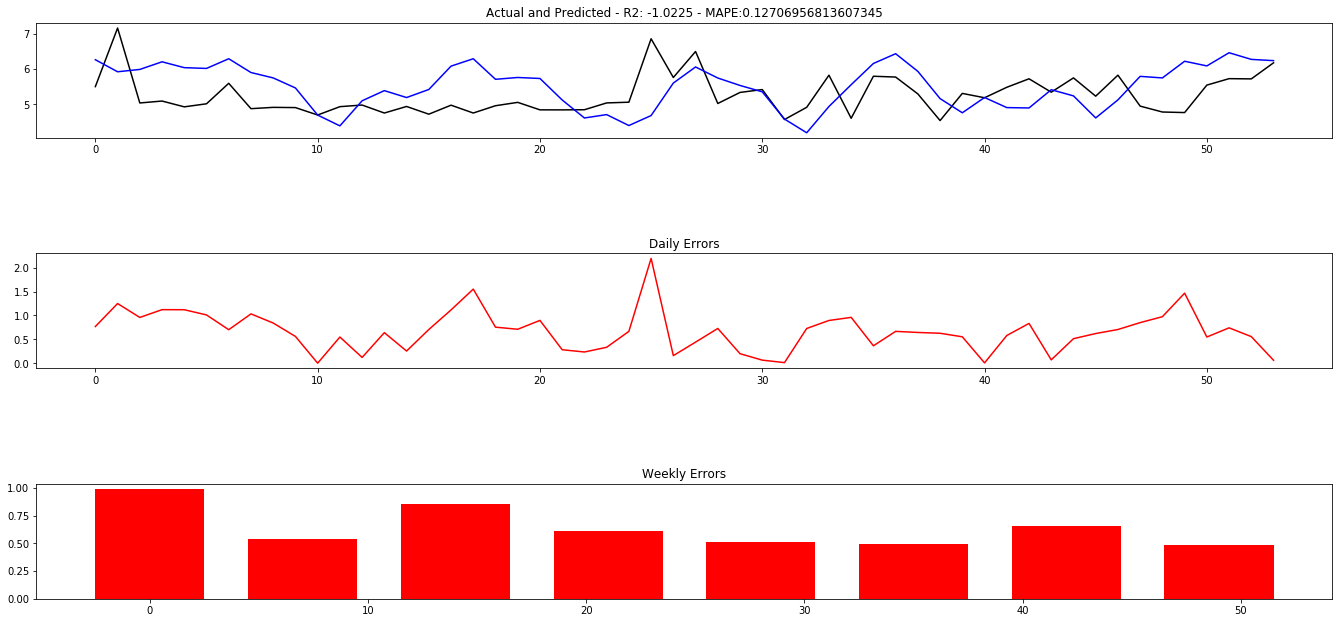

In [35]:
t = prices.shape[0]-60
t_r = prices.shape[0]
plot_prediction(non_norm_y[t:t_r], pred_yy[t:t_r])

# Last 'a' pred

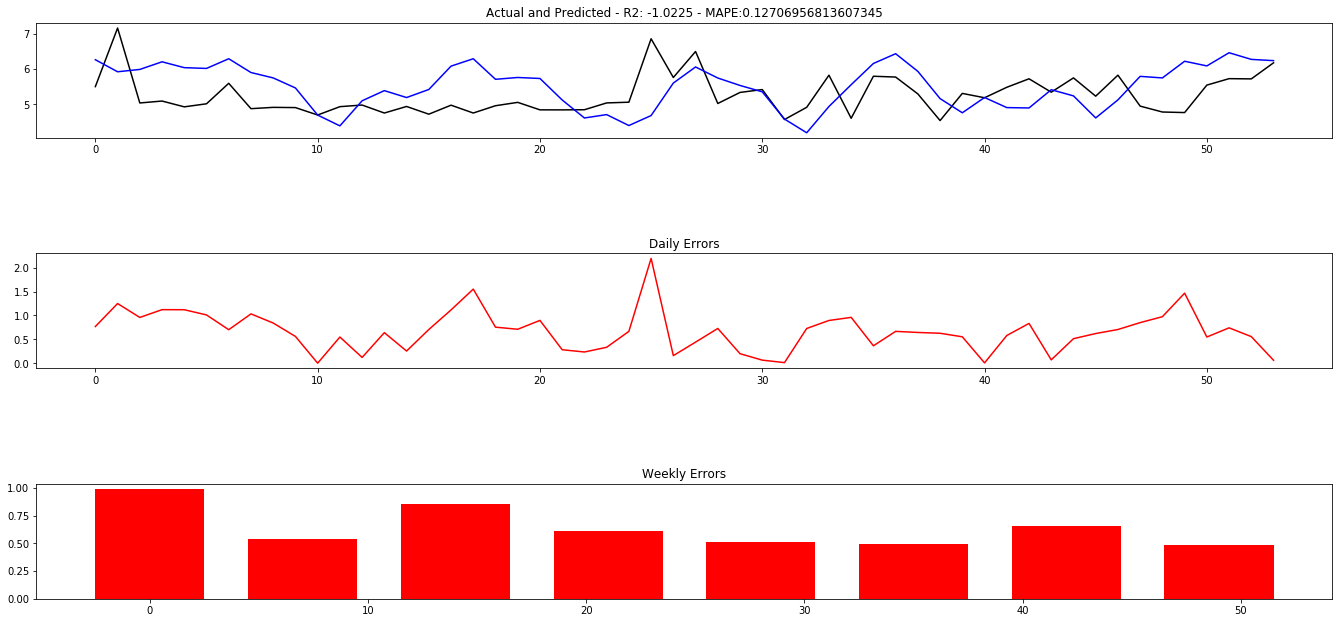

In [36]:
a = 60
t = prices.shape[0]-a
t_r = prices.shape[0]
plot_prediction(non_norm_y[t:t_r], pred_yy[t:t_r])